In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import seaborn as sns
import pandas as pd
from keras.datasets import mnist
from icecream import ic
from keras.utils import to_categorical
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
import warnings

np.set_printoptions(linewidth=200, suppress=True, precision=3)

In [3]:
class Layer:
    def __init__(self):
        self.cache = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.normal(0, 1, (input_size, output_size))
        self.bias = np.random.normal(0, 1, (output_size))
        self.gW = 0
        self.gB = 0

    def forward(self, input):
        out = np.dot(input, self.weights) + self.bias
        self.cache = input
        return out

    def backward(self, output_gradient, learning_rate):
        X = self.cache
        # input grad
        dX = np.dot(output_gradient, self.gW.T).reshape(X.shape)
        
        self.gW = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, output_gradient)
        self.gB = np.sum(output_gradient, axis=0)
        
        # update
        self.weights -= learning_rate * self.gW
        self.bias -= learning_rate * self.gB
        return dX

class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

class Softmax(Layer):
    def __init__(self):
        self.cache = None

    def forward(self, input):
        maxes = np.amax(input, axis=1)
        maxes = maxes.reshape(maxes.shape[0], 1)
        Y = np.exp(input - maxes)
        Z = Y / np.sum(Y, axis=1).reshape(Y.shape[0], 1)
        self.cache = (input, Y, Z)
        return Z # distribution

    def backward(self, output_gradient, learning_rate):
        X, Y, Z = self.cache
        dZ = np.zeros(X.shape)
        dY = np.zeros(X.shape)
        dX = np.zeros(X.shape)
        N = X.shape[0]
        for n in range(N):
            i = np.argmax(Z[n])
            dZ[n,:] = np.diag(Z[n]) - np.outer(Z[n],Z[n])
            M = np.zeros((N,N))
            M[:,i] = 1
            dY[n,:] = np.eye(N) - M
        dX = np.dot(output_gradient,dZ)
        dX = np.dot(dX,dY)
        return dX

class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.cache = None
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.cache = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        X = self.cache
        return np.multiply(output_gradient, self.activation_prime(X))

class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            return sigmoid(x) * (1 - sigmoid(x))

        super().__init__(sigmoid, sigmoid_prime)

class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0, x)

        def relu_prime(x):
            return np.where(x > 0, 1, 0)

        super().__init__(relu, relu_prime)


class NeuralNetwork:
    def __init__(self, model, loss, loss_prime):
        self.model = model
        self.loss = loss
        self.loss_prime = loss_prime

        self.history_loss = []
        self.history_accuracy = []

    def predict(self, input):
        output = input
        for layer in self.model:
            output = layer.forward(output)
        return output

    def train(
        self,
        x_train,
        y_train,
        epochs=1000,
        learning_rate=10e-5,
        batch_size=32,
    ):

        for e in tqdm(range(epochs), desc="Epoch"):
            error = 0
            correct = 0

            indices = np.arange(x_train.shape[0])
            np.random.shuffle(indices)
            x_train = x_train[indices]
            y_train = y_train[indices]

            for x, y in zip(x_train, y_train):
                # forward
                output = self.predict(x)

                if (np.argmax(output) == np.argmax(y)):
                    correct += 1

                # error
                error += self.loss(y, output)

                # backward
                grad = self.loss_prime(y, output)
                for layer in reversed(self.model):
                    grad = layer.backward(grad, learning_rate)

            self.history_loss.append(error / len(x_train))
            self.history_accuracy.append(correct / len(y_train))

    def show_train_history(self, size = (8,6)):
        fig, ax = plt.subplots(1, 2, figsize = size)
        ax[0].plot(self.history_loss)
        ax[0].set_title('Loss')
        ax[1].plot(self.history_accuracy)
        ax[1].set_title('Accuracy')

In [4]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def cross_entropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    log_likelihood = -np.log(y_pred)
    loss = np.sum(y_true * log_likelihood) / n_samples
    return loss


def derivative_cross_entropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    d_loss = (y_pred - y_true) / n_samples
    return d_loss

In [5]:
# # @title Iris Test
# iris = datasets.load_iris()
# data_x = iris.data.reshape(iris.data.shape[0], 4, 1)
# cat = to_categorical(iris.target)
# data_y = cat.reshape(cat.shape[0], 3, 1)

# X_train, X_test, y_train, y_test = train_test_split(
#     data_x, data_y, test_size=0.3, random_state=777
# )

# np.random.seed(23)
# perseptron = NeuralNetwork(
#     [Dense(4, 10), Tanh(), Dense(10, 10), Tanh(), Dense(10, 3), Softmax()],
#     cross_entropy,
#     derivative_cross_entropy
# )

# perseptron.train(X_train, y_train, learning_rate=10e-3, epochs=100, batch_size=100)
# perseptron.show_train_history()

# predictions = [
#     np.argmax(perseptron.predict(x)) for x in X_test]
# print(classification_report([np.argmax(y) for y in y_test], predictions))



In [6]:
import warnings

def plot_class_distribution(classes):
    # Suppress all warnings
    warnings.filterwarnings("ignore")

    sns.countplot(x = classes)
    plt.title('Распределение классов')
    plt.xlabel('Цифры')
    plt.show()

    # Reset the warning filter to its default state
    warnings.filterwarnings("default")

def reduce_dataset(X, y, reduce_to):
    # Создать пустые списки для хранения индексов
    idx = []

    # Для каждого класса от 0 до 9
    for i in range(10):
        # Найти индексы примеров, соответствующих данному классу
        idx_i = np.where(y == i)[0]
        # Случайным образом выбрать подмножество индексов
        idx_i = np.random.choice(idx_i, size=reduce_to, replace=False)
        # Добавить индексы в списки
        idx.extend(idx_i)

    # Перемешать индексы
    np.random.shuffle(idx)
    # Сократить датасет с помощью индексов
    return (X[idx], y[idx])

In [21]:
np.random.seed(0)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

X, y = reduce_dataset(X, y, 500)

# plot_class_distribution(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777)

# Prereprocessing
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train -= np.mean(X_train)
X_test -= np.mean(X_test)

print(X_train.shape)

(3500, 784)


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

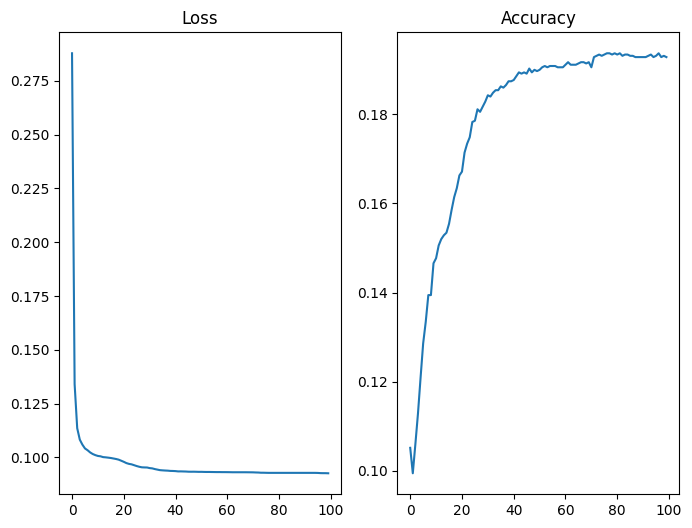

In [15]:
simple_net = NeuralNetwork(
    [Dense(28*28, 300), ReLU(), Dense(300, 10), Sigmoid()],
    mse,
    mse_prime
)

simple_net.train(X_train, y_train, learning_rate=0.01, epochs=100, batch_size=100)
simple_net.show_train_history()


In [19]:
predictions = [
    np.argmax(simple_net.predict(x)) for x in X_test]
print(classification_report([np.argmax(y) for y in y_test], predictions))

              precision    recall  f1-score   support

           0       0.17      0.23      0.19       150
           1       0.43      0.92      0.58       156
           2       0.11      0.07      0.08       146
           3       0.04      0.02      0.03       161
           4       0.12      0.15      0.13       144
           5       0.20      0.37      0.26       145
           6       0.06      0.03      0.04       161
           7       0.16      0.08      0.11       146
           8       0.06      0.03      0.04       143
           9       0.11      0.08      0.09       148

    accuracy                           0.20      1500
   macro avg       0.15      0.20      0.16      1500
weighted avg       0.15      0.20      0.16      1500

